In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
n_x = 5
n_u = 2

@jax.jit
def car_continuous_dynamics(x, u):
    # x = [x position, y position, heading, speed, steering angle]
    # u = [acceleration, steering velocity]
    heading = x[2]
    v = x[3]
    steer = x[4]
    x_d = jnp.array(
        [v * jnp.cos(heading), v * jnp.sin(heading), v * jnp.tan(steer), u[0], u[1]]
    )
    return x_d

In [3]:
def discrete_dynamics(x, u):
    dt = 0.1
    # TODO: Fill in the Euler integrator below and return the next state

    x_next = x + dt * car_continuous_dynamics(x, u)
    return x_next

In [4]:
def rollout(x0, u_trj):
    x_trj = np.zeros((u_trj.shape[0] + 1, x0.shape[0]))
    # TODO: Define the rollout here and return the state trajectory x_trj: [N, number of states]
    x_trj[0] = x0
    for i, u in enumerate(u_trj):
        x_trj[i+1] = discrete_dynamics(x_trj[i], u)
    return x_trj


# Debug your implementation with this example code
N = 10
x0 = np.array([1, 0, 0, 1, 0])
u_trj = np.zeros((N - 1, n_u))
x_trj = rollout(x0, u_trj)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [5]:
r = 2.0
v_target = 2.0
eps = 1e-6  # The derivative of sqrt(x) at x=0 is undefined. Avoid by subtle smoothing

@jax.jit
def cost_stage(x, u):
    
    c_circle = (jnp.sqrt(x[0] ** 2 + x[1] ** 2 + eps) - r) ** 2
    c_speed = (x[3] - v_target) ** 2
    c_control = (u[0] ** 2 + u[1] ** 2) * 0.1
    return c_circle + c_speed + c_control

@jax.jit
def cost_final(x):
    c_circle = (jnp.sqrt(x[0] ** 2 + x[1] ** 2 + eps) - r) ** 2
    c_speed = (x[3] - v_target) ** 2
    return c_circle + c_speed

In [6]:
@jax.jit
def cost_trj(x_trj, u_trj):
    total = 0.0
    # TODO: Sum up all costs
    total = (
        cost_final(x_trj[-1])+
        jnp.sum(jnp.array([cost_stage(x, u) for x, u in zip(x_trj[:-1], u_trj)]))
    )

    return total


# Debug your code
cost_trj(x_trj, u_trj)

Array(13.849996, dtype=float32)

In [7]:
@jax.jit
def deriv_stage(x, u, l=cost_stage):
    l_x = jax.jacrev(l, argnums=0)
    l_u = jax.jacrev(l, argnums=1)
    l_xx = jax.jacfwd(l_x, argnums=0)
    l_ux = jax.jacfwd(l_u, argnums=0)
    l_uu = jax.jacfwd(l_u, argnums=1)

    return l_x(x, u), l_u(x, u), l_xx(x, u), l_ux(x, u), l_uu(x, u)

@jax.jit
def deriv_final(x, l_final=cost_final):
    l_final_x = jax.jacrev(l_final, argnums=0)
    l_final_xx = jax.jacfwd(l_final_x, argnums=0)
    return l_final_x(x), l_final_xx(x)

@jax.jit
def deriv_dynamics(x, u, f=discrete_dynamics):
    f_x, f_u = jax.jacrev(f, argnums=(0, 1))(x, u)
    return f_x, f_u

In [8]:
x = np.array([0., 0., 0., 0., 0.])
u = np.array([0., 0.])
print(deriv_stage(x, u))
print(deriv_final(x))
print(deriv_dynamics(x, u))

(Array([ 0.,  0.,  0., -4.,  0.], dtype=float32), Array([0., 0.], dtype=float32), Array([[-3.9979998e+03,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00],
       [ 0.0000000e+00, -3.9979998e+03,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  2.0000000e+00,
         0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00]], dtype=float32), Array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]], dtype=float32), Array([[0.2, 0. ],
       [0. , 0.2]], dtype=float32))
(Array([ 0.,  0.,  0., -4.,  0.], dtype=float32), Array([[-3.9979998e+03,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00],
       [ 0.0000000e+00, -3.9979998e+03,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0

In [9]:
@jax.jit
def Q_terms(l_x, l_u, l_xx, l_ux, l_uu, f_x, f_u, V_x, V_xx):
    # TODO: Define the Q-terms here
    Q_x = l_x + V_x.T @ f_x #np.zeros(l_x.shape)
    Q_u = l_u + V_x.T @ f_u #np.zeros(l_u.shape)
    Q_xx = l_xx + f_x.T @ V_xx @ f_x #np.zeros(l_xx.shape)
    Q_ux = l_ux + f_u.T @ V_xx @ f_x #np.zeros(l_ux.shape)
    Q_uu = l_uu + f_u.T @ V_xx @ f_u #np.zeros(l_uu.shape)
    return Q_x, Q_u, Q_xx, Q_ux, Q_uu

In [10]:
@jax.jit
def gains(Q_uu, Q_u, Q_ux):
    Q_uu_inv = jnp.linalg.inv(Q_uu)
    # TODO: Implement the feedforward gain k and feedback gain K.
    k = - Q_uu_inv @ Q_u.T  #np.zeros(Q_u.shape)
    K = - Q_uu_inv @ Q_ux #np.zeros(Q_ux.shape)
    return k, K

In [11]:
@jax.jit
def V_terms(Q_x, Q_u, Q_xx, Q_ux, Q_uu, K, k):
    # TODO: Implement V_x and V_xx, hint: use the A.dot(B) function for matrix multiplcation.
    V_x = Q_x + K.T @ Q_u + k.T @ Q_ux + K.T @ Q_uu @ k #np.zeros(Q_x.shape)
    # print(Q_xx.shape, Q_ux.T.shape, K.shape, K.T.shape, Q_ux.shape, K.shape)  #np.zeros(Q_xx.shape)
    V_xx = Q_xx + 2 * Q_ux.T @ K + K.T @ Q_uu @ K  #np.zeros(Q_xx.shape) 
    
    return V_x, V_xx

In [12]:
@jax.jit
def expected_cost_reduction(Q_u, Q_uu, k):
    return -Q_u.T @ k - 0.5 * k.T @ Q_uu @ k

In [13]:
def forward_pass(x_trj, u_trj, k_trj, K_trj, fd=discrete_dynamics):
    x_trj_new = np.zeros(x_trj.shape)
    x_trj_new[0, :] = x_trj[0, :]
    u_trj_new = np.zeros(u_trj.shape)
    # TODO: Implement the forward pass here
    for n in range(u_trj.shape[0]):
        # Note, converting from deviation variable to actual value variable
        u_trj_new[n,:] = u_trj[n,:] + k_trj[n,:] + K_trj[n,:] @ (x_trj_new[n,:]-x_trj[n,:])# Apply feedback law
        x_trj_new[n+1,:] = fd(x_trj_new[n,:], u_trj_new[n,:]) # Apply dynamics
    return x_trj_new, u_trj_new

In [14]:
def backward_pass(x_trj, u_trj, regu):
    k_trj = np.zeros([u_trj.shape[0], u_trj.shape[1]])
    K_trj = np.zeros([u_trj.shape[0], u_trj.shape[1], x_trj.shape[1]])
    expected_cost_redu = 0
    # TODO: Set terminal boundary condition here (V_x, V_xx)
    V_x, V_xx = deriv_final(x_trj[-1])
    # print(V_x, V_xx)
    # print(x_trj.shape[1], u_trj.shape[1])
    # V_x = np.zeros((x_trj.shape[1],))
    # V_xx = np.zeros((x_trj.shape[1], x_trj.shape[1]))
    for n in range(u_trj.shape[0] - 1, -1, -1):
        # TODO: First compute derivatives, then the Q-terms
        l_x, l_u, l_xx, l_ux, l_uu = deriv_stage(x_trj[n], u_trj[n])
        f_x, f_u = deriv_dynamics(x_trj[n], u_trj[n])

        Q_x, Q_u, Q_xx, Q_ux, Q_uu = Q_terms(l_x, l_u, l_xx, l_ux, l_uu, f_x, f_u, V_x, V_xx)
        # print('Qx',Q_x,'Qu', Q_u, 'Qxx', Q_xx, 'Qux', Q_ux, 'Quu', Q_uu)
        # Q_x = np.zeros((x_trj.shape[1],))
        # Q_u = np.zeros((u_trj.shape[1],))
        # Q_xx = np.zeros((x_trj.shape[1], x_trj.shape[1]))
        # Q_ux = np.zeros((u_trj.shape[1], x_trj.shape[1]))
        # Q_uu = np.zeros((u_trj.shape[1], u_trj.shape[1]))
        # We add regularization to ensure that Q_uu is invertible and nicely conditioned
        Q_uu_regu = Q_uu + jnp.eye(Q_uu.shape[0]) * regu
        # print(Q_uu_regu, Q_u, Q_ux)
        k, K = gains(Q_uu_regu, Q_u, Q_ux)
        k_trj[n, :] = k
        K_trj[n, :, :] = K
        V_x, V_xx = V_terms(Q_x, Q_u, Q_xx, Q_ux, Q_uu, K, k)
        # print(Q_u, Q_uu, k)
        expected_cost_redu += expected_cost_reduction(Q_u, Q_uu, k)
    return k_trj, K_trj, expected_cost_redu

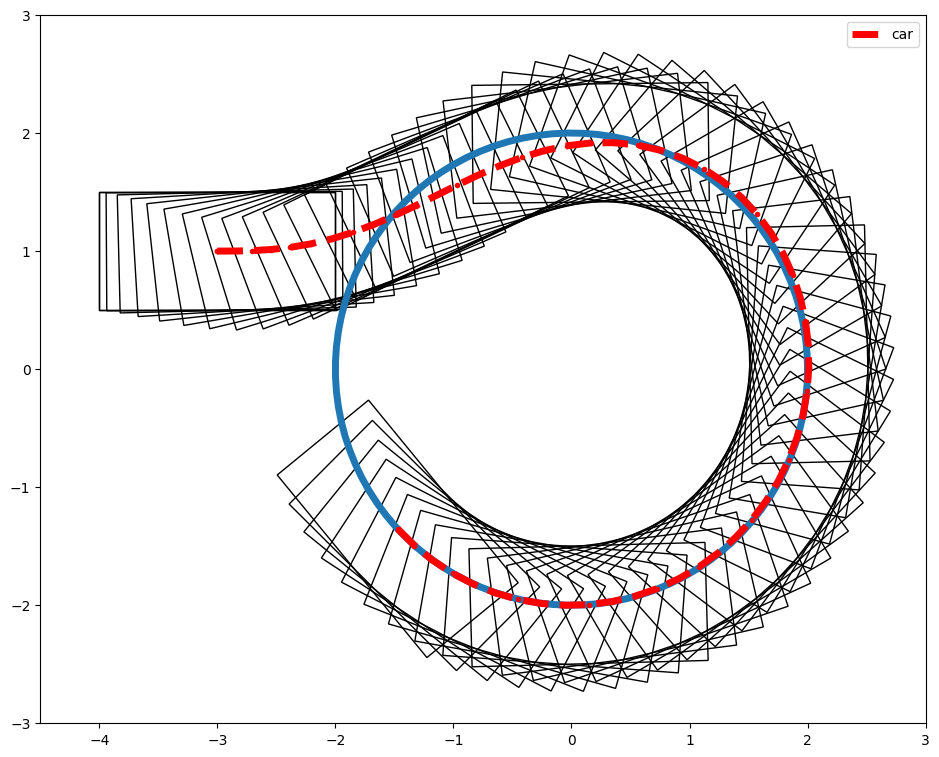

In [20]:
def run_ilqr(x0, N, max_iter=50, regu_init=100):
    # First forward rollout
    u_trj = np.random.randn(N - 1, n_u) * 0.0001
    x_trj = rollout(x0, u_trj)
    total_cost = cost_trj(x_trj, u_trj)
    regu = regu_init
    max_regu = 10000
    min_regu = 0.01

    # Setup traces
    cost_trace = [total_cost]
    expected_cost_redu_trace = []
    redu_ratio_trace = [1]
    redu_trace = []
    regu_trace = [regu]

    # Run main loop
    for it in range(max_iter):
        # Backward and forward pass
        k_trj, K_trj, expected_cost_redu = backward_pass(x_trj, u_trj, regu)
        x_trj_new, u_trj_new = forward_pass(x_trj, u_trj, k_trj, K_trj)
        # Evaluate new trajectory
        total_cost = cost_trj(x_trj_new, u_trj_new)
        cost_redu = cost_trace[-1] - total_cost
        redu_ratio = cost_redu / abs(expected_cost_redu)
        # Accept or reject iteration
        if cost_redu > 0:
            # Improvement! Accept new trajectories and lower regularization
            redu_ratio_trace.append(redu_ratio)
            cost_trace.append(total_cost)
            x_trj = x_trj_new
            u_trj = u_trj_new
            regu *= 0.7
        else:
            # Reject new trajectories and increase regularization
            regu *= 2.0
            cost_trace.append(cost_trace[-1])
            redu_ratio_trace.append(0)
        regu = min(max(regu, min_regu), max_regu)
        regu_trace.append(regu)
        redu_trace.append(cost_redu)

        # Early termination if expected improvement is small
        if expected_cost_redu <= 1e-6:
            break

    return x_trj, u_trj, cost_trace, regu_trace, redu_ratio_trace, redu_trace


# Setup problem and call iLQR
x0 = jnp.array([-3.0, 1.0, -0.0, 0.0, 0.0])
N = 60
max_iter = 300
regu_init = 100
x_trj, u_trj, cost_trace, regu_trace, redu_ratio_trace, redu_trace = run_ilqr(
    x0, N, max_iter, regu_init
)


plt.figure(figsize=(9.5, 8))
# Plot circle
theta = np.linspace(0, 2 * np.pi, 100)
plt.plot(r * np.cos(theta), r * np.sin(theta), linewidth=5)
ax = plt.gca()

# Plot resulting trajecotry of car
plt.plot(x_trj[:, 0], x_trj[:, 1], 'r.--',linewidth=5, label='car')
w = 2.0
h = 1.0

# Plot rectangles
for n in range(x_trj.shape[0]):
    rect = mpl.patches.Rectangle((-w / 2, -h / 2), w, h, fill=False)
    t = (
        mpl.transforms.Affine2D()
        .rotate_deg_around(0, 0, np.rad2deg(x_trj[n, 2]))
        .translate(x_trj[n, 0], x_trj[n, 1])
        + ax.transData
    )
    rect.set_transform(t)
    ax.add_patch(rect)
ax.set_aspect(1)
plt.ylim((-3, 3))
plt.xlim((-4.5, 3))
plt.tight_layout()
plt.legend()

# Try it on the Cart-Pole Problem

In [9]:
n_x = 4
n_u = 1
s_goal = np.array([0.0, np.pi, 0.0, 0.0])

@jax.jit
def cartpole_continuous_dynamics(s, u):
    """Compute the cart-pole state derivative."""
    mp = 2.0  # pendulum mass
    mc = 10.0  # cart mass
    L = 1.0  # pendulum length
    g = 9.81  # gravitational acceleration

    x, θ, dx, dθ = s
    sinθ, cosθ = jnp.sin(θ), jnp.cos(θ)
    h = mc + mp * (sinθ**2)
    ds = jnp.array(
        [
            dx,
            dθ,
            (mp * sinθ * (L * (dθ**2) + g * cosθ) + u[0]) / h,
            -((mc + mp) * g * sinθ + mp * L * (dθ**2) * sinθ * cosθ + u[0] * cosθ)
            / (h * L),
        ]
    )
    return ds

In [10]:
def discrete_dynamics(x, u):
    dt = 0.1
    # TODO: Fill in the Euler integrator below and return the next state

    x_next = x + dt * cartpole_continuous_dynamics(x, u)
    return x_next

In [11]:
def rollout(x0, u_trj):
    x_trj = np.zeros((u_trj.shape[0] + 1, x0.shape[0]))
    # TODO: Define the rollout here and return the state trajectory x_trj: [N, number of states]
    x_trj[0] = x0
    for i, u in enumerate(u_trj):
        x_trj[i+1] = discrete_dynamics(x_trj[i], u)
    return x_trj


# Debug your implementation with this example code
N = 20
x0 = np.array([1, 1, 0, 0])
u_trj = np.zeros((N - 1, n_u))
x_trj = rollout(x0, u_trj)
x_trj

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


array([[ 1.        ,  1.        ,  0.        ,  0.        ],
       [ 1.        ,  1.        ,  0.07813676, -0.86770052],
       [ 1.00781369,  0.91322994,  0.16737266, -1.74139786],
       [ 1.02455091,  0.73909014,  0.29437488, -2.59546447],
       [ 1.05398846,  0.47954369,  0.46713185, -3.38396311],
       [ 1.10070169,  0.14114738,  0.64551473, -3.99483371],
       [ 1.16525316, -0.25833601,  0.71745783, -4.20406771],
       [ 1.23699892, -0.67874277,  0.58048022, -3.82101727],
       [ 1.29504693, -1.06084454,  0.32168072, -3.00369096],
       [ 1.32721496, -1.36121368,  0.11247955, -2.04538703],
       [ 1.33846295, -1.56575239,  0.01026905, -1.06458831],
       [ 1.33948982, -1.67221117, -0.0094446 , -0.08350128],
       [ 1.33854532, -1.6805613 ,  0.00693564,  0.89411658],
       [ 1.33923888, -1.59114969,  0.01150366,  1.86971331],
       [ 1.34038925, -1.40417838, -0.043425  ,  2.84939218],
       [ 1.3360467 , -1.11923909, -0.20434667,  3.84349513],
       [ 1.31561208, -0.

In [12]:
Q = np.diag(np.array([10.0, 10.0, 2.0, 2.0]))  # state cost matrix
R = 1e-2 * np.eye(n_u)  # control cost matrix
QN = 1e2 * np.eye(n_x)  # terminal state cost matrix

@jax.jit
def cost_stage(x, u):
    return 1/2 * ((x-s_goal).T @ Q @ (x-s_goal) + u.T @ R @ u)

@jax.jit
def cost_final(x):
    return 1/2 * ((x-s_goal).T @ QN @ (x-s_goal))

In [13]:
@jax.jit
def cost_trj(x_trj, u_trj):
    total = 0.0
    # TODO: Sum up all costs
    total = (
        cost_final(x_trj[-1])+
        jnp.sum(jnp.array([cost_stage(x, u) for x, u in zip(x_trj[:-1], u_trj)]))
    )

    return total


# Debug your code
cost_trj(x_trj, u_trj)

Array(3587.6636, dtype=float32)

In [14]:
@jax.jit
def deriv_stage(x, u, l=cost_stage):
    l_x = jax.jacrev(l, argnums=0)
    l_u = jax.jacrev(l, argnums=1)
    l_xx = jax.jacfwd(l_x, argnums=0)
    l_ux = jax.jacfwd(l_u, argnums=0)
    l_uu = jax.jacfwd(l_u, argnums=1)

    return l_x(x, u), l_u(x, u), l_xx(x, u), l_ux(x, u), l_uu(x, u)

@jax.jit
def deriv_final(x, l_final=cost_final):
    l_final_x = jax.jacrev(l_final, argnums=0)
    l_final_xx = jax.jacfwd(l_final_x, argnums=0)
    return l_final_x(x), l_final_xx(x)

@jax.jit
def deriv_dynamics(x, u, f=discrete_dynamics):
    f_x, f_u = jax.jacrev(f, argnums=(0, 1))(x, u)
    return f_x, f_u

In [15]:
x = np.array([0., 0., 0., 0.])
u = np.array([0.])
# print(deriv_stage(x, u))
print(cost_final(x), deriv_final(x))
# print(deriv_dynamics(x, u))

493.48026 (Array([   0.     , -314.15927,    0.     ,    0.     ], dtype=float32), Array([[100.,   0.,   0.,   0.],
       [  0., 100.,   0.,   0.],
       [  0.,   0., 100.,   0.],
       [  0.,   0.,   0., 100.]], dtype=float32))


In [16]:
# u_now = u_trj[0]
# u_now.T @ R @ u_now

In [50]:
def run_ilqr(x0, N, max_iter=50, regu_init=100):
    np.random.seed(2)
    # First forward rollout
    u_trj = np.zeros((N - 1, n_u))#np.random.randn(N - 1, n_u) * 0.0001 # 
    x_trj = np.zeros((N, n_x))#rollout(x0, u_trj)
    total_cost = cost_trj(x_trj, u_trj)
    regu = regu_init
    max_regu = 10000
    min_regu = 0.01

    # Setup traces
    cost_trace = [total_cost]
    expected_cost_redu_trace = []
    redu_ratio_trace = [1]
    redu_trace = []
    regu_trace = [regu]

    counter = 0

    # Run main loop
    for it in range(max_iter):
        # Backward and forward pass
        k_trj, K_trj, expected_cost_redu = backward_pass(x_trj, u_trj, regu)
        x_trj_new, u_trj_new = forward_pass(x_trj, u_trj, k_trj, K_trj)
        # Evaluate new trajectory
        total_cost = cost_trj(x_trj_new, u_trj_new)
        cost_redu = cost_trace[-1] - total_cost
        redu_ratio = cost_redu / abs(expected_cost_redu)
        # Accept or reject iteration
        if cost_redu > 0:
            # Improvement! Accept new trajectories and lower regularization
            redu_ratio_trace.append(redu_ratio)
            cost_trace.append(total_cost)
            x_trj = x_trj_new
            u_trj = u_trj_new
            regu *= 0.7
        else:
            # Reject new trajectories and increase regularization
            regu *= 2.0
            cost_trace.append(cost_trace[-1])
            redu_ratio_trace.append(0)
        regu = min(max(regu, min_regu), max_regu)
        regu_trace.append(regu)
        redu_trace.append(cost_redu)
        

        print(counter, expected_cost_redu, total_cost, regu)
        # Early termination if expected improvement is small
        if expected_cost_redu <= 1e-10:
            break

        
        counter += 1
    return x_trj, u_trj, k_trj, K_trj, cost_trace, regu_trace, redu_ratio_trace, redu_trace


# Setup problem and call iLQR
x0 = jnp.array([0.0, 0.0, 0.0, 0.0])
T = 10
t = np.arange(0.0, T, 0.1)
N = len(t)
max_iter = 1000
regu_init = 0
x_trj, u_trj, k_trj, K_trj, cost_trace, regu_trace, redu_ratio_trace, redu_trace = run_ilqr(
    x0, N, max_iter, regu_init
)

0 240.07764 5174.8433 0.01
1 61.514267 5113.172 0.01
2 6.335702 5104.765 0.01
3 4.08198 5099.0977 0.01
4 2.9229577 5094.7905 0.01
5 2.543293 5090.9 0.01
6 2.4693077 5087.0244 0.01
7 2.6087265 5082.8643 0.01
8 2.920381 5078.1694 0.01
9 3.3942747 5072.7183 0.01
10 4.0270085 5066.3096 0.01
11 4.809935 5058.775 0.01
12 5.722057 5050.0063 0.01
13 6.7392373 5039.947 0.01
14 7.8439927 5028.5977 0.01
15 9.007348 5016.002 0.01
16 10.20266 5002.242 0.01
17 11.448063 4987.4277 0.01
18 12.732412 4971.6245 0.01
19 14.019531 4954.967 0.01
20 15.367579 4937.5615 0.01
21 16.732552 4919.3994 0.01
22 18.052107 4900.675 0.01
23 19.41708 4881.3667 0.01
24 20.696104 4861.477 0.01
25 21.890188 4841.247 0.01
26 23.082428 4820.4478 0.01
27 24.091974 4799.3584 0.01
28 25.078197 4777.9307 0.01
29 25.986528 4756.0825 0.01
30 26.730375 4734.1733 0.01
31 27.556593 4711.7534 0.01
32 28.129799 4689.409 0.01
33 28.839417 4666.6157 0.01
34 29.336641 4643.8555 0.01
35 29.894133 4620.8296 0.01
36 30.375166 4597.6895 0.0

/tmp/ipykernel_160864/3634773443.py:8: RuntimeWarning: invalid value encountered in matmul
  u_trj_new[n,:] = u_trj[n,:] + k_trj[n,:] + K_trj[n,:] @ (x_trj_new[n,:]-x_trj[n,:])# Apply feedback law


125 28.796349 2561.1223 0.013999999999999999
126 27.458088 2571.692 0.027999999999999997
127 25.141249 2564.1194 0.055999999999999994
128 16.560564 2545.1748 0.03919999999999999
129 17.783037 2533.377 0.027439999999999992
130 13.054651 2857.6682 0.054879999999999984
131 14.015747 2520.5623 0.038415999999999985
132 18.88228 2509.334 0.026891199999999987
133 21.626019 2490.8015 0.01882383999999999
134 21.082924 2478.458 0.013176687999999994
135 28.769476 2484.093 0.026353375999999987
136 22.606062 2458.958 0.01844736319999999
137 19.156694 2613.1147 0.03689472639999998
138 22.997028 2470.4504 0.07378945279999996
139 16.263151 2450.8726 0.05165261695999997
140 169.63644 2563.879 0.10330523391999993
141 12.986052 2452.4915 0.20661046783999987
142 9.170788 2444.1086 0.1446273274879999
143 7.670446 2436.7688 0.10123912924159992
144 23.79557 9069.737 0.20247825848319984
145 5.4351416 2431.4739 0.14173478093823988
146 6.052518 2425.5593 0.09921434665676791
147 7.291882 2418.2654 0.069450042659

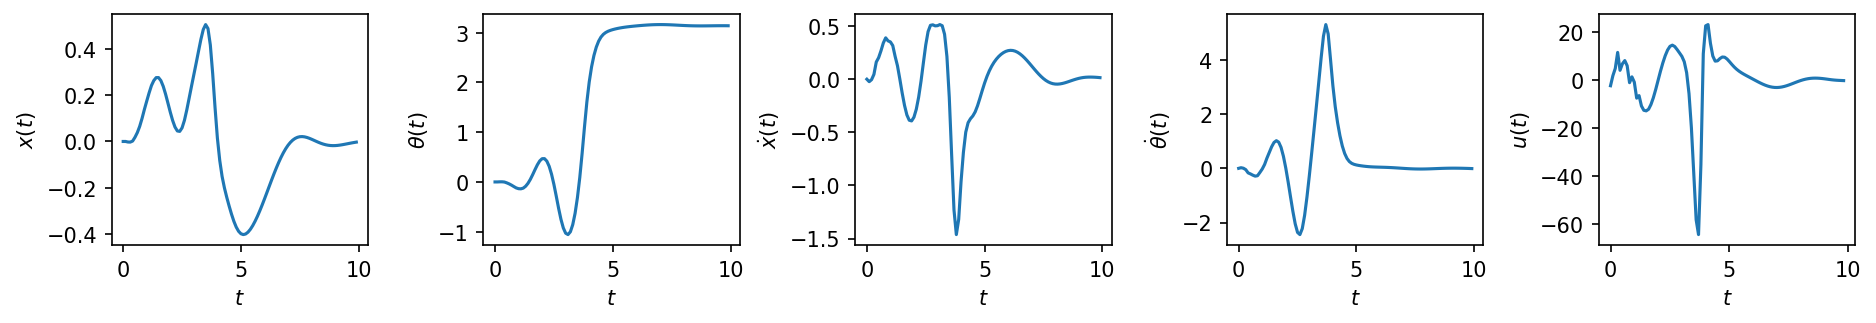

In [51]:
# Plot iLQR solution
fig, axes = plt.subplots(1, n_x + n_u, dpi=150, figsize=(15, 2))
plt.subplots_adjust(wspace=0.45)
labels_s = (r"$x(t)$", r"$\theta(t)$", r"$\dot{x}(t)$", r"$\dot{\theta}(t)$")
labels_u = (r"$u(t)$",)
for i in range(n_x):
    axes[i].plot(t, x_trj[:, i])
    axes[i].set_xlabel(r"$t$")
    axes[i].set_ylabel(labels_s[i])
for i in range(n_u):
    axes[n_x + i].plot(t[:-1], u_trj[:, i])
    
    axes[n_x + i].set_xlabel(r"$t$")
    axes[n_x + i].set_ylabel(labels_u[i])


In [45]:
import time
from scipy.integrate import odeint

print("Simulating ... ", end="", flush=True)
start = time.time()
s = np.zeros((N, n_x))
u = np.zeros((N-1, n_u))
s[0] = x0
closed_loop = False
for k in range(N-1):
    # PART (d) ################################################################
    # INSTRUCTIONS: Compute either the closed-loop or open-loop value of
    # `u[k]`, depending on the Boolean flag `closed_loop`.
    if closed_loop:
        u[k] = u_trj[k] + k_trj[k,:] + K_trj[k,:] @ (s[k,:]-x_trj[k,:])
        # raise NotImplementedError()
    else:  # do open-loop control
        u[k] = u_trj[k]
        # raise NotImplementedError()
    ###########################################################################
    s[k + 1] = odeint(lambda s, t: cartpole_continuous_dynamics(s, u[k]), s[k], t[k : k + 2])[1]
print("done! ({:.2f} s)".format(time.time() - start), flush=True)

Simulating ... done! (0.09 s)


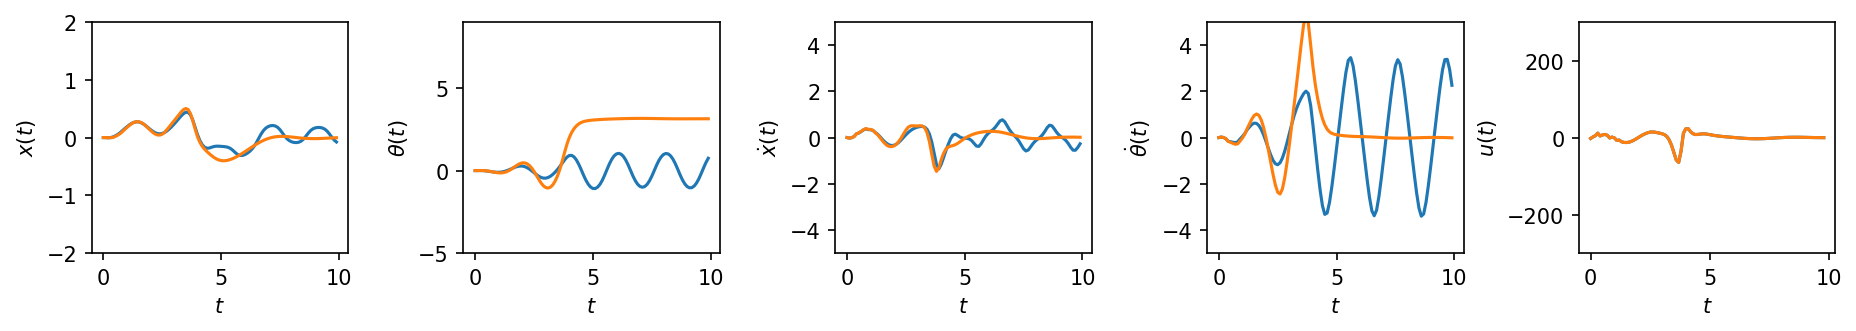

In [46]:
%matplotlib inline
fig, axes = plt.subplots(1, n_x + n_u, dpi=150, figsize=(15, 2))
plt.subplots_adjust(wspace=0.45)
labels_s = (r"$x(t)$", r"$\theta(t)$", r"$\dot{x}(t)$", r"$\dot{\theta}(t)$")
labels_u = (r"$u(t)$",)
for i in range(n_x):
    axes[i].plot(t, s[:, i])
    axes[i].set_xlabel(r"$t$")
    axes[i].set_ylabel(labels_s[i])
for i in range(n_u):
    axes[n_x + i].plot(t[:-1], u[:, i])
    axes[n_x + i].set_xlabel(r"$t$")
    axes[n_x + i].set_ylabel(labels_u[i])

for i in range(n_x):
    axes[i].plot(t, x_trj[:, i])
    axes[i].set_xlabel(r"$t$")
    axes[i].set_ylabel(labels_s[i])
for i in range(n_u):
    axes[n_x + i].plot(t[:-1], u_trj[:, i])
    
    axes[n_x + i].set_xlabel(r"$t$")
    axes[n_x + i].set_ylabel(labels_u[i])

axes[0].set_ylim([-2, 2])
axes[1].set_ylim([-5, 9])
axes[2].set_ylim([-5, 5])
axes[3].set_ylim([-5, 5])
axes[4].set_ylim([-300, 300])

# if closed_loop:
#     plt.savefig("cartpole_swingup_cl.png", bbox_inches="tight")
# else:
#     plt.savefig("cartpole_swingup_ol.png", bbox_inches="tight")
plt.show()

In [101]:
x_trj.shape

(100, 4)